In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/mental-health-in-tech-survey/survey.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


# PreProcessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from category_encoders import BinaryEncoder

# Splitting Data
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

# Tuning
from sklearn.model_selection import GridSearchCV

In [3]:
# Load the dataset
data = pd.read_csv("/kaggle/input/mental-health-in-tech-survey/survey.csv")

# Display the first few rows of the dataset
print("Rows and Columns in this dataset:", data.shape)
data.head()


Rows and Columns in this dataset: (1259, 27)


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [4]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)


Missing values:
 Timestamp                       0
Age                             0
Gender                          0
Country                         0
state                         515
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1095
dtype: int64


In [5]:
# Dropping 'state' and 'comments' columns
data_cleaned = data.drop(['state', 'comments'], axis=1)

# Display the shape of the cleaned dataset
print("Shape of the cleaned dataset:", data_cleaned.shape)

# Display the first few rows of the cleaned dataset
data_cleaned.head()


Shape of the cleaned dataset: (1259, 25)


,Timestamp,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,2014-08-27 11:29:31,37,Female,United States,NaN,No,Yes,Often,6-25,No,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,2014-08-27 11:29:37,44,M,United States,NaN,No,No,Rarely,More than 1000,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,2014-08-27 11:29:44,32,Male,Canada,NaN,No,No,Rarely,6-25,No,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,2014-08-27 11:30:22,31,Male,United States,NaN,No,No,Never,100-500,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [6]:
# Impute missing values for 'self_employed' and 'work_interfere' columns with the mode
data_cleaned['self_employed'].fillna(data_cleaned['self_employed'].mode()[0], inplace=True)
data_cleaned['work_interfere'].fillna(data_cleaned['work_interfere'].mode()[0], inplace=True)

# Check for missing values after imputation
missing_values_after_imputation = data_cleaned.isnull().sum()
print("Missing values after imputation:\n", missing_values_after_imputation)


Missing values after imputation:
 Timestamp                    0
Age                          0
Gender                       0
Country                      0
self_employed                0
family_history               0
treatment                    0
work_interfere               0
no_employees                 0
remote_work                  0
tech_company                 0
benefits                     0
care_options                 0
wellness_program             0
seek_help                    0
anonymity                    0
leave                        0
mental_health_consequence    0
phys_health_consequence      0
coworkers                    0
supervisor                   0
mental_health_interview      0
phys_health_interview        0
mental_vs_physical           0
obs_consequence              0
dtype: int64


In [7]:
# Encoding categorical variables
# One-hot encoding for columns with multiple categories
columns_to_onehot = ['Country', 'no_employees', 'leave']
data_encoded = pd.get_dummies(data_cleaned, columns=columns_to_onehot, drop_first=True)


# Binary encoding for binary categorical variables
binary_encoder = BinaryEncoder(cols=['Gender', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'remote_work', 
                                     'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 
                                     'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 
                                     'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence'])
data_encoded = binary_encoder.fit_transform(data_encoded)

# Scaling numerical features
numerical_columns = ['Age']
scaler = MinMaxScaler()
data_encoded[numerical_columns] = scaler.fit_transform(data_encoded[numerical_columns])

# Display the first few rows of the encoded and scaled dataset
data_encoded.head()


,Timestamp,Age,Gender_0,Gender_1,Gender_2,Gender_3,Gender_4,Gender_5,self_employed_0,self_employed_1,...,Country_Zimbabwe,no_employees_100-500,no_employees_26-100,no_employees_500-1000,no_employees_6-25,no_employees_More than 1000,leave_Somewhat difficult,leave_Somewhat easy,leave_Very difficult,leave_Very easy
0,2014-08-27 11:29:31,1.763000e-08,0,0,0,0,0,1,0,1,...,False,False,False,False,True,False,False,True,False,False
1,2014-08-27 11:29:37,1.770000e-08,0,0,0,0,1,0,0,1,...,False,False,False,False,False,True,False,False,False,False
2,2014-08-27 11:29:44,1.758000e-08,0,0,0,0,1,1,0,1,...,False,False,False,False,True,False,True,False,False,False
3,2014-08-27 11:29:46,1.757000e-08,0,0,0,0,1,1,0,1,...,False,False,True,False,False,False,True,False,False,False
4,2014-08-27 11:30:22,1.757000e-08,0,0,0,0,1,1,0,1,...,False,True,False,False,False,False,False,False,False,False


In [8]:
# Creating Age Groups
bins = [0, 20, 30, 40, 50, 60, np.inf]
labels = [1, 2, 3, 4, 5, 6]  # Numerical labels corresponding to each age group
data_encoded['Age_Group'] = pd.cut(data_encoded['Age'], bins=bins, labels=labels, right=False)


# Combining Binary Features
# For example, combining 'mental_health_consequence' and 'phys_health_consequence'
data_encoded['Consequence'] = data_encoded['mental_health_consequence_1'] | data_encoded['phys_health_consequence_1']

# Extracting Information from Timestamps
data_encoded['Timestamp'] = pd.to_datetime(data_encoded['Timestamp'])
data_encoded['Day_of_Week'] = data_encoded['Timestamp'].dt.dayofweek
data_encoded['Month'] = data_encoded['Timestamp'].dt.month
data_encoded['Hour'] = data_encoded['Timestamp'].dt.hour

# Drop original columns used for feature engineering
data_encoded.drop(['Age', 'Timestamp', 'mental_health_consequence_1', 'phys_health_consequence_1'], axis=1, inplace=True)

# Display the first few rows of the dataset with engineered features
data_encoded.head()


,Gender_0,Gender_1,Gender_2,Gender_3,Gender_4,Gender_5,self_employed_0,self_employed_1,family_history_0,family_history_1,...,no_employees_More than 1000,leave_Somewhat difficult,leave_Somewhat easy,leave_Very difficult,leave_Very easy,Age_Group,Consequence,Day_of_Week,Month,Hour
0,0,0,0,0,0,1,0,1,0,1,...,False,False,True,False,False,1,1,2,8,11
1,0,0,0,0,1,0,0,1,0,1,...,True,False,False,False,False,1,1,2,8,11
2,0,0,0,0,1,1,0,1,0,1,...,False,True,False,False,False,1,1,2,8,11
3,0,0,0,0,1,1,0,1,1,0,...,False,True,False,False,False,1,1,2,8,11
4,0,0,0,0,1,1,0,1,0,1,...,False,False,False,False,False,1,1,2,8,11


In [25]:
# Check data types of columns
print(data_encoded.dtypes)


Gender_0       int64
Gender_1       int64
Gender_2       int64
Gender_3       int64
Gender_4       int64
               ...  
Consequence    int64
Day_of_Week    int32
Month          int32
Hour           int32
Cluster        int32
Length: 105, dtype: object


In [10]:
# Check columns of the dataset
print(data_encoded.columns)


Index(['Gender_0', 'Gender_1', 'Gender_2', 'Gender_3', 'Gender_4', 'Gender_5',
       'self_employed_0', 'self_employed_1', 'family_history_0',
       'family_history_1',
       ...
       'no_employees_More than 1000', 'leave_Somewhat difficult',
       'leave_Somewhat easy', 'leave_Very difficult', 'leave_Very easy',
       'Age_Group', 'Consequence', 'Day_of_Week', 'Month', 'Hour'],
      dtype='object', length=104)


Number of data points in each cluster:
Cluster
1    568
0    415
2    276
Name: count, dtype: int64


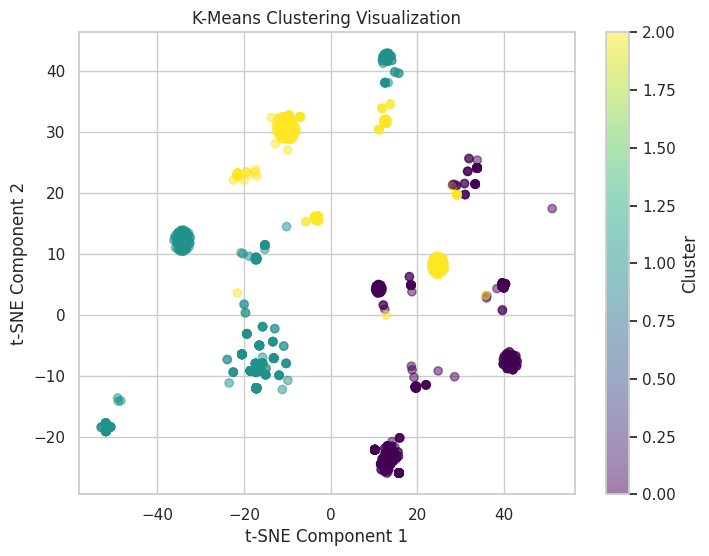

In [18]:
from sklearn.cluster import KMeans

# Define the features for clustering
features_for_clustering = ['Gender_0', 'Gender_1', 'Gender_2', 'Gender_3', 'Gender_4', 'Gender_5',
       'self_employed_0', 'self_employed_1', 'family_history_0',
       'family_history_1']

# Extract features for clustering
X = data_encoded[features_for_clustering]

# Instantiate KMeans with desired number of clusters (K)
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit KMeans to the data
kmeans.fit(X)

# Get cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels to the dataset
data_encoded['Cluster'] = cluster_labels

# Display the number of data points in each cluster
print("Number of data points in each cluster:")
print(data_encoded['Cluster'].value_counts())

# Visualize the clusters (using t-SNE for dimensionality reduction)
from sklearn.manifold import TSNE

# Instantiate t-SNE with 2 components for visualization
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data to 2D
data_tsne = tsne.fit_transform(X)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('K-Means Clustering Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [20]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette_avg = silhouette_score(data_encoded, data_encoded['Cluster'])

# Print the silhouette score
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.02588282130105315


In [21]:
# Calculate the proportion of each feature within each cluster
cluster_feature_proportions = data_encoded.groupby('Cluster')[features_for_clustering].mean()

# Display the proportions
print("Proportion of each feature within each cluster:")
print(cluster_feature_proportions)


Proportion of each feature within each cluster:
         Gender_0  Gender_1  Gender_2  Gender_3  Gender_4  Gender_5  \
Cluster                                                               
0        0.014458  0.031325  0.084337  0.139759  0.730120  0.845783   
1        0.017606  0.003521  0.061620  0.022887  0.908451  0.859155   
2        0.021739  0.025362  0.032609  0.992754  0.097826  0.126812   

         self_employed_0  self_employed_1  family_history_0  family_history_1  
Cluster                                                                        
0               0.108434         0.891566          1.000000          0.000000  
1               0.096831         0.903169          0.000000          1.000000  
2               0.166667         0.833333          0.278986          0.721014  


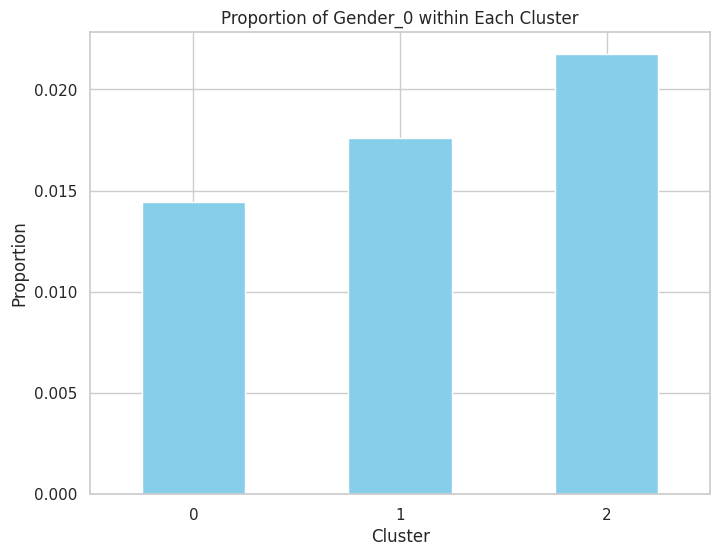

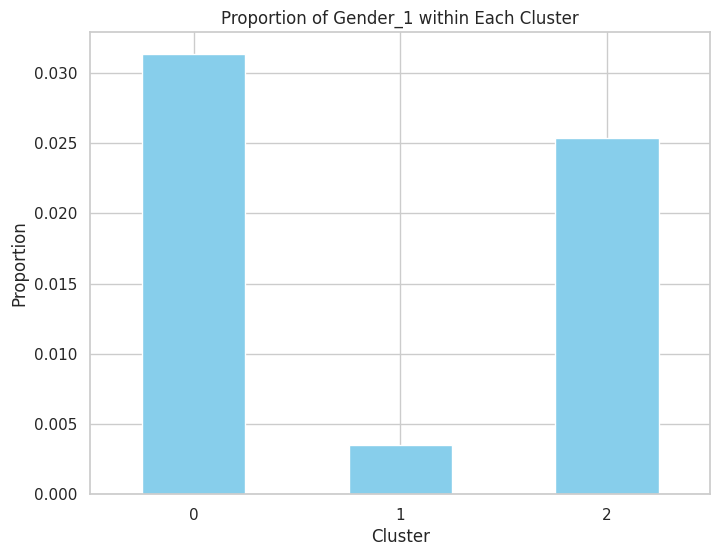

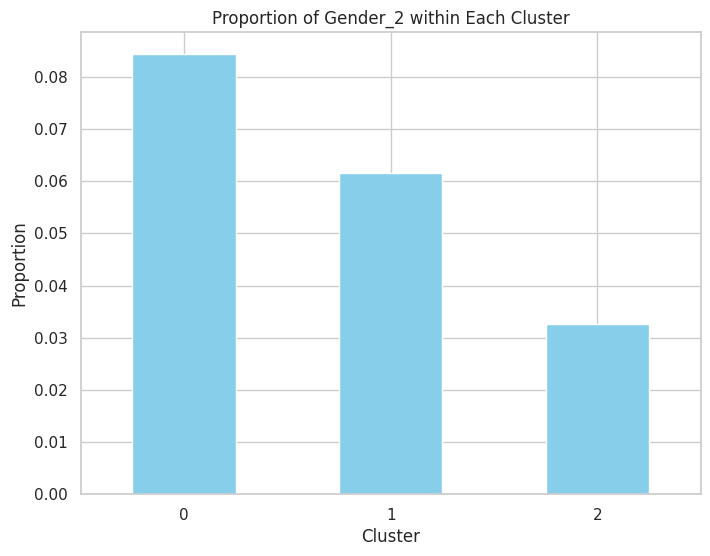

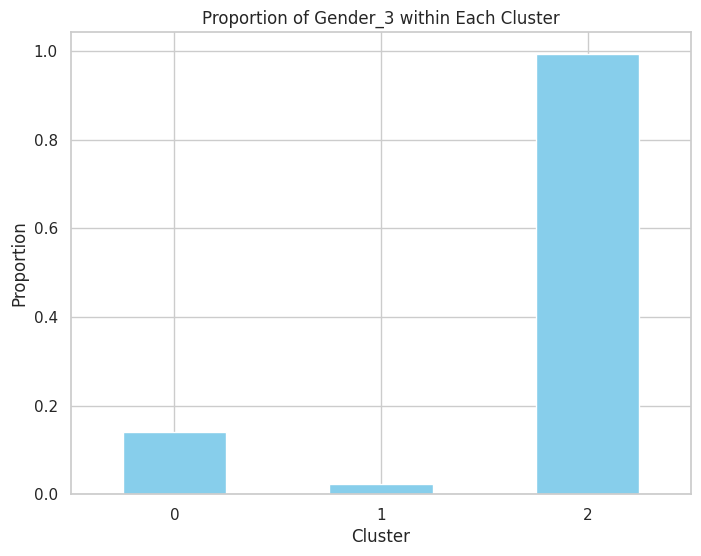

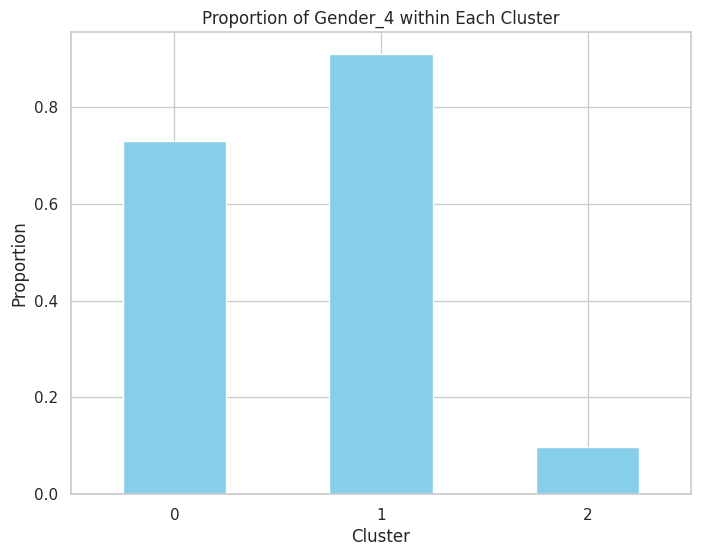

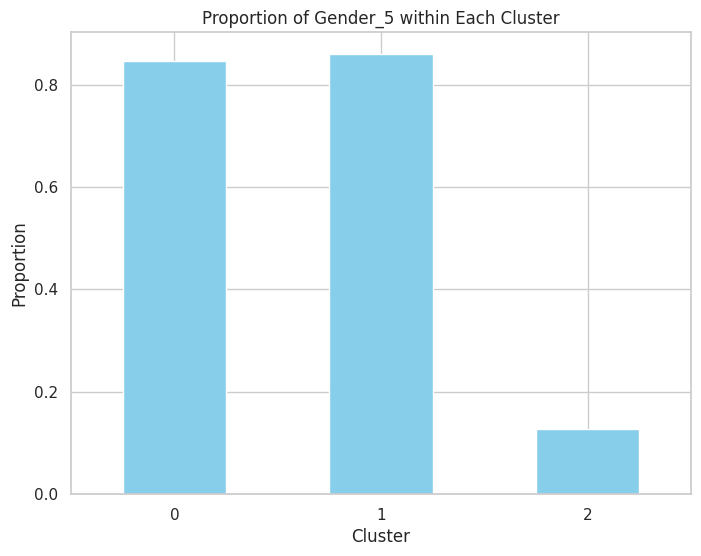

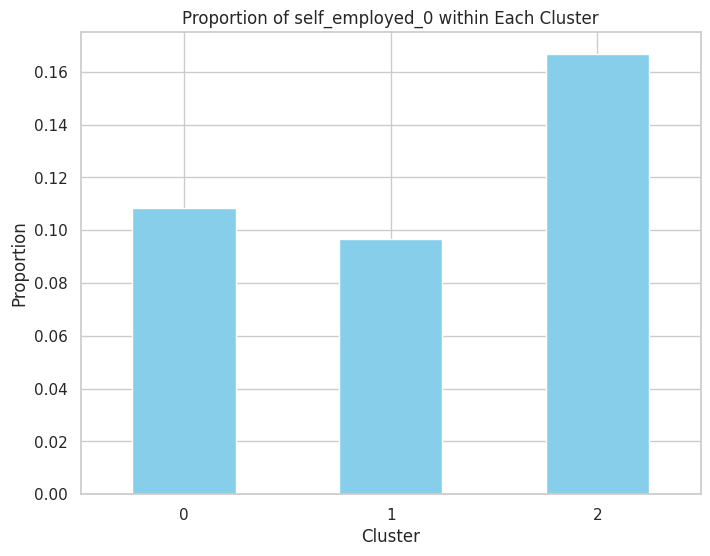

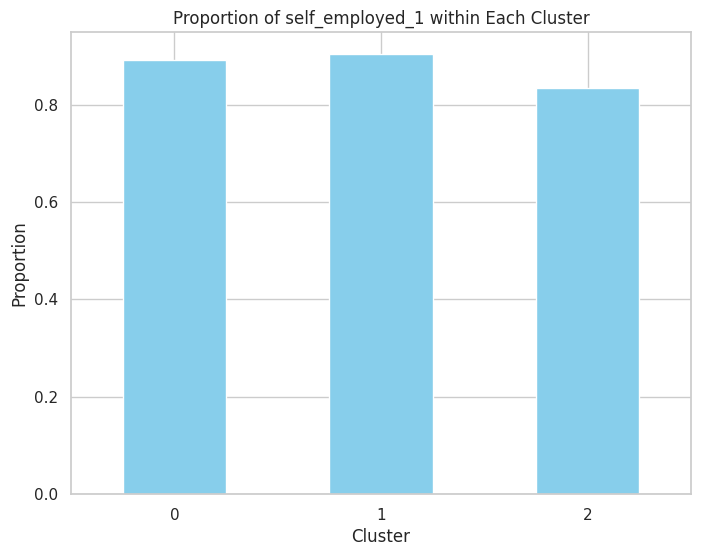

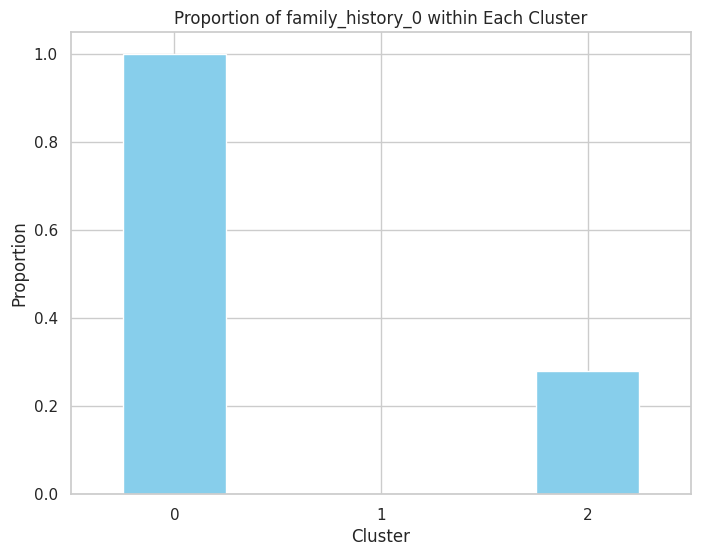

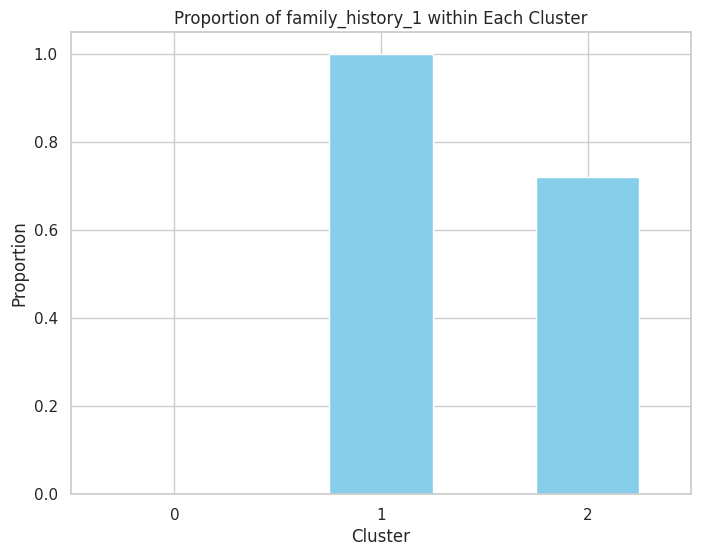

In [22]:
# Calculate the proportion of each feature within each cluster
cluster_feature_proportions = data_encoded.groupby('Cluster')[features_for_clustering].mean()

# Plot bar charts for each feature
for feature in features_for_clustering:
    plt.figure(figsize=(8, 6))
    cluster_feature_proportions[feature].plot(kind='bar', color='skyblue')
    plt.title(f'Proportion of {feature} within Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Proportion')
    plt.xticks(rotation=0)
    plt.show()


In [24]:
# Define cluster characteristics based on feature proportions
cluster_characteristics = []

for cluster_id, proportions in cluster_feature_proportions.iterrows():
    cluster_summary = f"Cluster {cluster_id} Characteristics:\n"
    predominant_gender = proportions[['Gender_0', 'Gender_1', 'Gender_2', 'Gender_3', 'Gender_4', 'Gender_5']].idxmax()
    self_employment_status = "Self-Employed" if proportions['self_employed_1'] > proportions['self_employed_0'] else "Not Self-Employed"
    family_history_of_mental_health = "Family History Present" if proportions['family_history_1'] > proportions['family_history_0'] else "No Family History"
    cluster_summary += f"- Predominant Gender: {predominant_gender}\n"
    cluster_summary += f"- Self-Employment Status: {self_employment_status}\n"
    cluster_summary += f"- Family History of Mental Health Issues: {family_history_of_mental_health}\n"
    cluster_characteristics.append(cluster_summary)

# Display cluster characteristics summary
print("Cluster Characteristics Summary:")
for summary in cluster_characteristics:
    print(summary)


Cluster Characteristics Summary:
Cluster 0 Characteristics:
- Predominant Gender: Gender_5
- Self-Employment Status: Self-Employed
- Family History of Mental Health Issues: No Family History

Cluster 1 Characteristics:
- Predominant Gender: Gender_4
- Self-Employment Status: Self-Employed
- Family History of Mental Health Issues: Family History Present

Cluster 2 Characteristics:
- Predominant Gender: Gender_3
- Self-Employment Status: Self-Employed
- Family History of Mental Health Issues: Family History Present

